In [1]:
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

Using TensorFlow backend.


In [2]:
# 此函數會幫我們把多張影像畫成一張多宮格圖
def img_combine(img, ncols=8, size=1, path=False):
    from math import ceil
    import matplotlib.pyplot as plt
    import numpy as np
    nimg = len(img)
    nrows = int(ceil(nimg/ncols))
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(ncols*size,nrows*size))
    if nrows == 0:
        return
    elif ncols == 1:
        for r, ax in zip(np.arange(nrows), axes):
            nth=r
            if nth < nimg:
                ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
                
            ax.set_axis_off()
    elif nrows == 1:
        for c, ax in zip(np.arange(ncols), axes):
            nth=c
            if nth < nimg:
                ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
            ax.set_axis_off()
    else:
        for r, row in zip(np.arange(nrows), axes):
            for c, ax in zip(np.arange(ncols), row):
                nth=r*ncols+c
                if nth < nimg:
                    ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
                ax.set_axis_off()
    plt.show()

In [68]:
# 讀取 Cifar-10 資料集
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

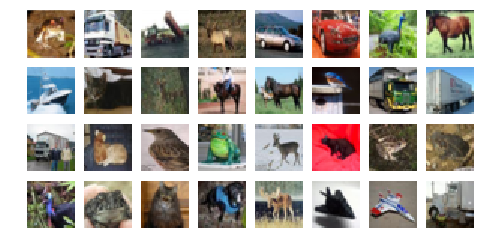

In [4]:
# 取前 32 張圖片做視覺化
images = x_train[:32]
img_combine(images)

In [38]:
# 建立 ImageDataGenerator，並指定我們要做資料增強的數值範圍
data_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

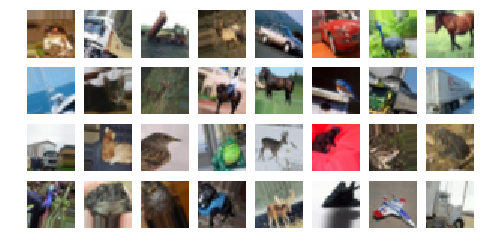

In [39]:
# 注意！！ ImageDataGenerator 是一個 Generator (生成器)! 對 Generator 不熟悉的同學請回到 Day098 做複習。
# 使用 .flow 後，就會對我們的影像進行增強，再 call next 取出 generator 的圖像。(shuffle=False 因為我們希望圖像的順序不要改變，方便觀察。實際訓練時預設是 shuffle=True) 
augmented_iamges = next(data_generator.flow(images, shuffle=False))
img_combine(augmented_iamges.astype("int")) # 注意在訓練時神經網路時，圖像資料必須要是 float32，但在做視覺化時要轉為 int 才能順利畫圖。所以為了畫圖才把資料轉為 int

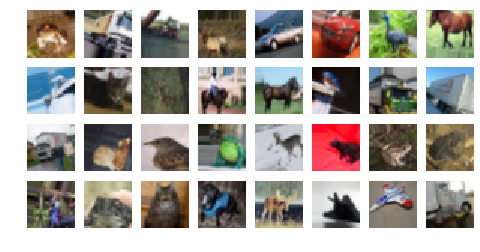

In [40]:
# 因為隨機性的關係，所以一樣的圖像再經過一次 generator 後的結果不一定相同
augmented_iamges = next(data_generator.flow(images, shuffle=False))
img_combine(augmented_iamges.astype("int"))

## 作業

請使用 ImageDataGenerator 來進行 Cifar-10 資料集的訓練，並觀察不同的圖像增強方法是否會顯著影響訓練結果

In [30]:
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import RMSprop, Adam
import os
import numpy as np

In [69]:
batch_size = 128 # batch 的大小，如果出現 OOM error，請降低這個值
num_classes = 10 # 類別的數量，Cifar 10 共有 10 個類別
epochs = 10 # 訓練的 epochs 數量

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [51]:
print(x_train.shape)
print(y_train.shape)

(10000, 32, 32, 3)
(10000, 10, 10)


In [47]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_19 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_20 (Activation)   (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 15, 15, 64)        18496     
__________

In [70]:
# 建立 ImageDataGenerator，並指定我們要做資料增強的數值範圍
data_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
data_generator.fit(x_train)
train_generator = data_generator.flow(x_train, y_train, shuffle=False)

In [71]:
import math
'''
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])
'''
model.fit_generator(data_generator.flow(x_train, y_train),
                    math.ceil(len(x_train)/32),
                    epochs=10)

Epoch 1/10
1563/1563 [==============================] - 258s 165ms/step - loss: 1.7353 - acc: 0.3636
Epoch 2/10
1563/1563 [==============================] - 261s 167ms/step - loss: 1.4507 - acc: 0.4799
Epoch 3/10
1563/1563 [==============================] - 258s 165ms/step - loss: 1.3858 - acc: 0.5097
Epoch 4/10
1563/1563 [==============================] - 253s 162ms/step - loss: 1.3642 - acc: 0.5208
Epoch 5/10
1563/1563 [==============================] - 252s 161ms/step - loss: 1.3844 - acc: 0.5227
Epoch 6/10
1563/1563 [==============================] - 254s 162ms/step - loss: 1.4200 - acc: 0.5120
Epoch 7/10
1563/1563 [==============================] - 256s 164ms/step - loss: 1.4557 - acc: 0.5081
Epoch 8/10
1563/1563 [==============================] - 252s 161ms/step - loss: 1.4556 - acc: 0.5011
Epoch 9/10
1563/1563 [==============================] - 253s 162ms/step - loss: 1.4682 - acc: 0.5002
Epoch 10/10
1563/1563 [==============================] - 257s 165ms/step - loss: 1.4962 - a

In [23]:
import numpy as np
images = x_train[:32]
x2 = next(data_generator.flow(images, shuffle=False))
print(x_train.shape, type(x_train))
print(x2.shape, type(x2))
test = np.concatenate((x_train, x2))
print(test.shape, type(test))


(50000, 32, 32, 3) <class 'numpy.ndarray'>
(32, 32, 32, 3) <class 'numpy.ndarray'>
(50032, 32, 32, 3) <class 'numpy.ndarray'>


In [64]:
len(x_train)

10000

In [66]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

# 计算特征归一化所需的数量
# （如果应用 ZCA 白化，将计算标准差，均值，主成分）
datagen.fit(x_train)

# 使用实时数据增益的批数据对模型进行拟合：
model.fit_generator(datagen.flow(x_train, y_train, batch_size=32),
                    steps_per_epoch=len(x_train) / 32, epochs=epochs)


Epoch 1/10
  41/1562 [..............................] - ETA: 16:10 - loss: 2.2515 - acc: 0.1593

KeyboardInterrupt: 